In [1]:
__author__ = 'Team_4'
__Date__ = 'December 2018'

## Load Modules

In [20]:
from collections import defaultdict
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
from copy import deepcopy
from collections import Counter
import os
__dir__ = os.getcwd()[:-11]

from gensim.models.keyedvectors import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format(__dir__ + 'data/glove.6B.100d.bin')

import warnings
warnings.filterwarnings('ignore')


## Functions 

In [21]:
def make_pairs(words, max_len =6):
    patterns = defaultdict(list)

    for word in words:
        for second_word in words:
            if word != second_word:
                i = 1
                while(word[:i]==second_word[:i]):
                    i += 1
                if i != 1 and i > max(len(word[i-1:]), len(second_word[i-1:])) < max_len:
                    if ("suffix", word[i-1:], second_word[i-1:]) in patterns:
                        patterns[("suffix", word[i-1:], second_word[i-1:])].append((word, second_word))
                    else:
                        patterns[("suffix", word[i-1:], second_word[i-1:])] = [(word, second_word)]
                        
                i = 1
                while(word[-i:]==second_word[-i:]):
                    i += 1
                if i != 1 and max(len(word[:-i+1]), len(second_word[:-i+1])) < max_len:
                    if ("prefix", word[:-i+1], second_word[:-i+1]) in patterns:
                        patterns[("prefix", word[:-i+1], second_word[:-i+1])].append((word, second_word))
                    else:
                        patterns[("prefix", word[:-i+1], second_word[:-i+1])] = [(word, second_word)]
                        
    return patterns


def molph_classify(thepairs,model,threshold=0.5,min_category=5):
    new_pairs = defaultdict(list)

    for key in thepairs:
        cadidates = thepairs[key]
        
        similality = []
        for pair in cadidates:
            try:
                cos_sim = model(pair[0],pair[1])
            except:
                pass
            else: 
                if cos_sim > threshold:
                    similality.append(pair + (cos_sim,))
        
        if len(similality) > min_category :
             new_pairs[key] = similality
             
    return new_pairs


def make_same_group(pairs,word):
    pair_list = sum(list(pairs.values()),[])
    group = [pair for pair in pair_list if word==(pair[0] or pair[1])]
            
    return group


def plot_graph(pair_group):
    G = nx.Graph()
    for pair in pair_group:
        G.add_nodes_from([pair[0],pair[1]])
        G.add_edge(pair[0],pair[1])
    
    plt.figure(figsize=(7,7))
    pos = nx.spring_layout(G,k=0.7)
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=5000.0)
    nx.draw_networkx_edges(G, pos, width=2.5)
    nx.draw_networkx_labels(G, pos, fontsize=25, font_weight="bold")
    plt.axis('on')
    plt.show()
    

def get_hit_rate(pairs, words):
    hit_word = []
    pair_list = sum(list(pairs.values ()), [])
    for word in words:
        hit_word.extend([pair[1] for pair in pair_list if word == pair[0]])
        hit_word.extend([pair[0] for pair in pair_list if word == pair[1]])

    c = Counter(hit_word)
    
    return [(pair[0],int(pair[1]/2)) for pair in c.most_common(100)]
    

def clustering_group(pairs):
    pair_list1 = [set(pair[0:2]) for pair in sum(list(pairs.values()), [])]
    pair_list2 = deepcopy(pair_list1)
    cluster_list = []
    for pair1 in pair_list1[:]:
        ald = False
        for cluster in cluster_list:
            if pair1 <= cluster:
                ald = True
        if ald:
            continue

        while True:
            calc = False
            for pair2 in pair_list2[:]:
                if pair1 >= pair2:
                    pass
                elif not pair1.isdisjoint (pair2):
                    pair1 = pair1 | pair2
                    calc = True
            if not calc:
                cluster_list.append (pair1)
                break

    return cluster_list

## The Dataset

In [22]:
with open(__dir__ + 'data/english_brown.txt') as f:
    data = f.read()
    data = data.replace('.','')
    data = data.replace(',','')
    data = data.replace('""','')
    data = data.lower()

all_words = data.split()
words_set = np.unique(all_words)
words_set = [word for word in words_set if word.isalpha()]
words_set[:5]

['a', 'aaron', 'aau', 'abandoned', 'abandonment']

## Model for comparing consine similalities

In [23]:
model = word_vectors.similarity

## Making cadidates with same suffix and prefix

In [24]:
original_pair = make_pairs(words_set, max_len =6)

## Caluculating the cosine similalities to eliminate the unrelated words

In [25]:
pairs = molph_classify(original_pair,model,threshold=0.7,min_category=5)

## Graph

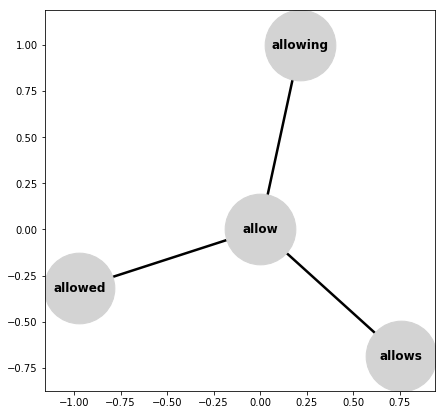

In [32]:
group = make_same_group(pairs,'allow')
plot_graph(group)

## Calculating Hit Rate

In [34]:
group = clustering_group(pairs)
get_hit_rate(pairs,group[100])

[('investigation', 4),
 ('investigate', 3),
 ('investigating', 3),
 ('investigated', 3),
 ('investigations', 1)]